In [119]:
import base64
import datetime
import json
import os
import random
import time

import scipy
from scipy import ndimage
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import statsmodels as sm
from pylab import rcParams
from pylab import *
from matplotlib.dates import date2num , DateFormatter
from PIL import Image

np.random.seed(1337)

%matplotlib inline
sns.set(font_scale=1.0)
rcParams['figure.figsize'] = 8, 6
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 1000

# Load the Data

In [120]:
raw_data = pd.read_json('tmp/raw_data.json', convert_dates=['created'])

raw_data.index.name = 'id'
d = raw_data[['created']]
print len(d)

124011


In [121]:
d.created.iloc[0]

Timestamp('2016-06-11 05:29:41')

In [122]:
d.dtypes

created    datetime64[ns]
dtype: object

In [123]:
d.head()

,created
id,
0,2016-06-11 05:29:41
1,2016-06-24 06:36:34
10,2016-06-24 07:54:24
100,2016-06-03 04:29:40
1000,2016-06-11 06:17:35


### Split date of creation into more atomic, numeric features
   * created_month
   * created_day_of_month
   * created_dow
   * created_hour
   * created_minute
   * created_minute_of_the_day

In [124]:
#created_month

d.loc[:, 'created_month'] = d['created'].map(lambda x: x.month)
# created_day_of_month
d.loc[:, 'created_day_of_month'] = d['created'].map(lambda x: x.day)
# created_dow
d.loc[:, 'created_dow'] = d['created'].map(lambda x: x.dayofweek)
# created_hour
d.loc[:, 'created_hour'] = d['created'].map(lambda x: x.hour)
# created_minute
d.loc[:, 'created_minute'] = d['created'].map(lambda x: x.minute)
# created_minute
d.loc[:, 'created_minute_of_the_day'] = d['created'].map(lambda x: 60 * x.hour + x.minute )
d.head()

,created,created_month,created_day_of_month,created_dow,created_hour,created_minute,created_minute_of_the_day
id,,,,,,,
0,2016-06-11 05:29:41,6,11,5,5,29,329
1,2016-06-24 06:36:34,6,24,4,6,36,396
10,2016-06-24 07:54:24,6,24,4,7,54,474
100,2016-06-03 04:29:40,6,3,4,4,29,269
1000,2016-06-11 06:17:35,6,11,5,6,17,377


### Distance from daily peak

Find what is the global peak in a day for created values and compute time diff in minutes (or hours)
Let's find the busiest hour of the day and let's consider the middle of this hour the "peak minute".
And the


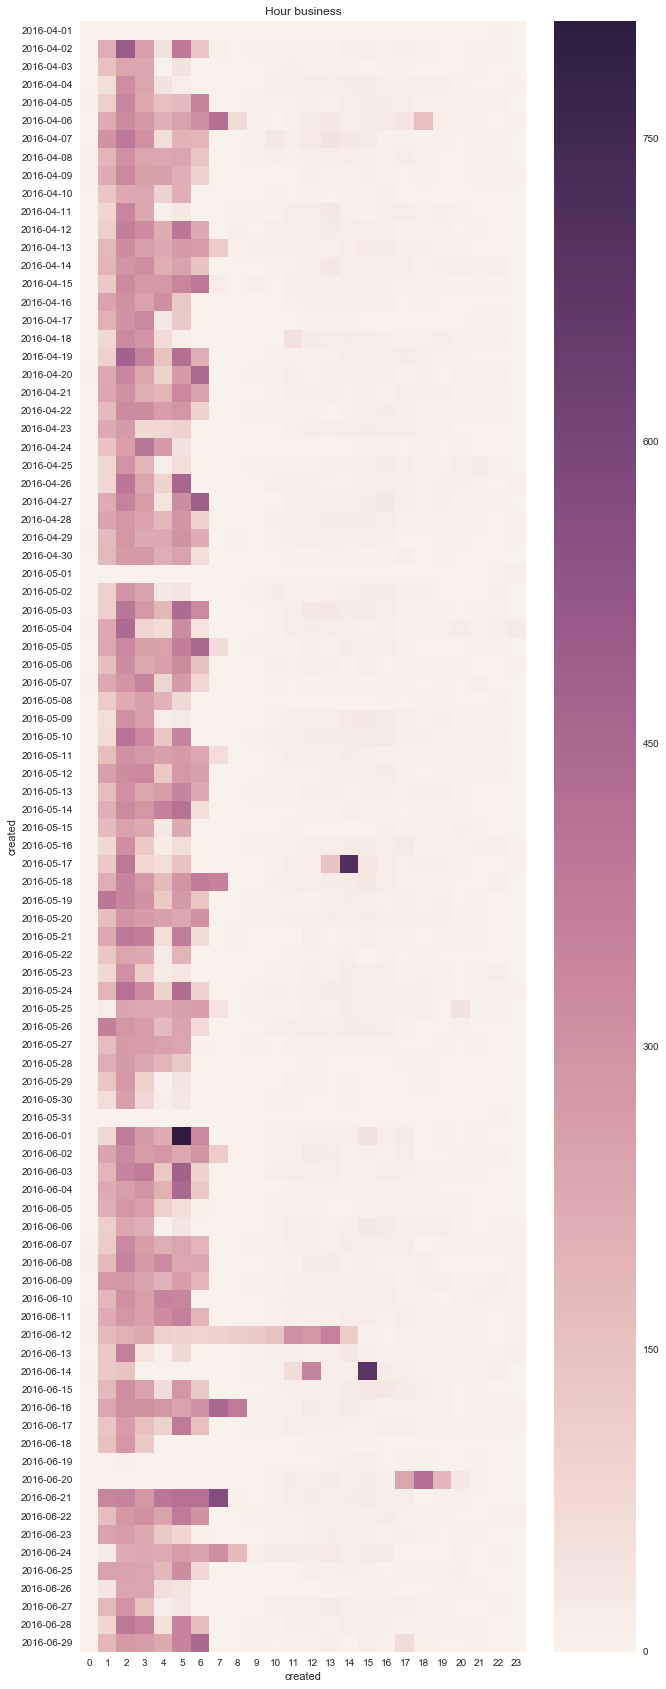

In [125]:
created_date = d.created.map(lambda x: x.date())
busy_hours_per_day = pd.crosstab(created_date, d['created_hour'])

plt.figure(figsize=(10, 30))
ax = sns.heatmap(
        data=busy_hours_per_day)
_ = ax.set_xlabel('created')
_ = ax.set_ylabel('created')
_ = ax.set_title('Hour business')

In [128]:
peak_hours = busy_hours_per_day.idxmax(axis=1).to_dict()
def distance_from_peak(created):
    min_of_day =  60 * created.hour + created.minute
    peak_hour = peak_hours[pd.to_datetime(created).date()]
    peak_hour_central_minute = 60 * peak_hour + 30
    return peak_hour_central_minute - min_of_day
    
d.loc[:, 'created_distance_from_peak'] = d.created.map(distance_from_peak)
d.head()

,created,created_month,created_day_of_month,created_dow,created_hour,created_minute,created_minute_of_the_day,created_distance_from_peak
id,,,,,,,,
0,2016-06-11 05:29:41,6,11,5,5,29,329,1
1,2016-06-24 06:36:34,6,24,4,6,36,396,54
10,2016-06-24 07:54:24,6,24,4,7,54,474,-24
100,2016-06-03 04:29:40,6,3,4,4,29,269,61
1000,2016-06-11 06:17:35,6,11,5,6,17,377,-47


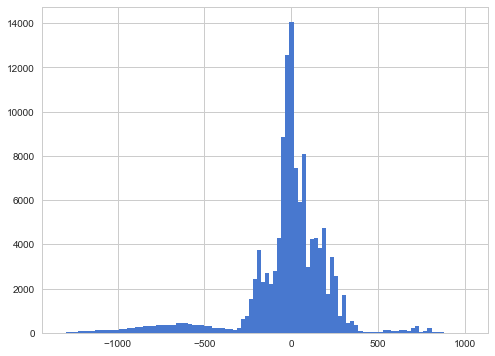

In [129]:
d.created_distance_from_peak.hist(bins=100)

In [130]:
# TODO 
# times in local timezones (days are messed u this way)

#Aggregated features

# num_apts_same_hour
# num_apts_prev_hour
# num_apts_next_hour
# num_apts_same_day
# num_apts_prev_day
# num_apts_next_day

# Save the Data

In [131]:
d.to_csv('tmp/features_created.csv')